# GOV.UK Transport Data

Install packages

In [2]:
%%capture
!pip install wget
!pip install odfpy

Import

In [3]:
import wget
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from google.colab import drive
import os

Download data from GOV.UK

In [4]:
url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/962249/COVID-19-transport-use-statistics.ods'
wget.download(url, 'ukgov-trans-data.ods')

'ukgov-trans-data.ods'

Convert from ODS to df  
*Data is formatted really annoyingly...*

In [5]:
df = pd.read_excel('ukgov-trans-data.ods', engine='odf', skiprows=6, nrows=352)
df.columns = ['date', 'cars', 'lcv', 'hgv', 'motor', 'train', 'tube', 'tflbus', 'bus', 'bike']
df.replace('..', np.nan, inplace=True)
df['date'] = pd.to_datetime(df['date'])

for col in ['train', 'cars', 'lcv']:
  df[col] = df[col].replace({'[^%]*$':'', 'p':'', 'r':''}, regex=True)
  for i in range(len(df[col])):
    try:
      df[col][i] = float(df[col][i])
    except ValueError:
      df[col][i] = float(df[col][i].strip('%'))/100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Mount the provided data too

In [7]:
drive.mount('/content/drive')
os.chdir("drive/My Drive/Citadel Datathon 2021")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

Plotting

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


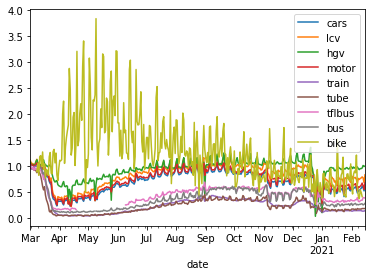

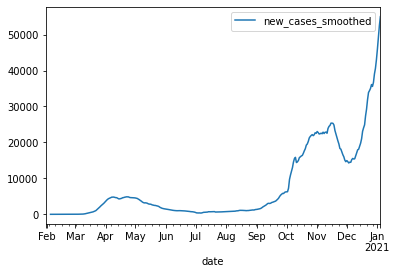

In [8]:
df.plot(x='date')

d2 = pd.read_csv("1_owid/owid-covid-data.csv")
uk = d2.loc[d2['iso_code'] == "GBR"]
uk['date'] = pd.to_datetime(uk['date'])
uk.plot(x='date', y='new_cases_smoothed')
plt.show()

Let's try, for each date, plotting mobility percentage against new cases  
Might see some sort of linear correlation?

First average the non-bike transport modes

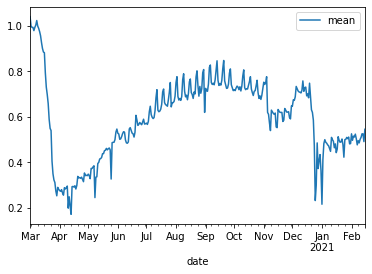

In [9]:
df['mean'] = df.iloc[:, 1:8].mean(axis=1)
df.plot(x='date', y='mean')
plt.show()

Slightly inelegant method of matching cases to mobility...  
*Ought to concatenate the tables with pandas*

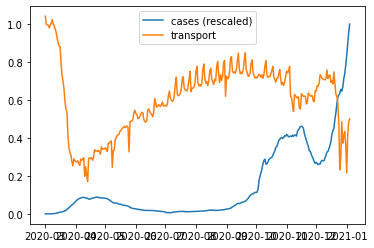

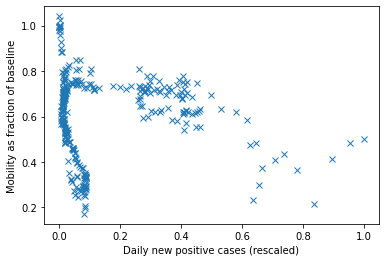

In [10]:
dates, cases, trans = [], [], []

for date in df['date']:
  try:
    cases.append(float(uk.loc[uk['date'] == date]['new_cases_smoothed']))
    trans.append(df.loc[df['date'] == date]['mean'])
    dates.append(date)
  except:
    continue

cases = np.array(cases)
# cases /= np.mean(cases)
cases = (cases - np.min(cases))/(np.max(cases) - np.min(cases))

plt.plot(dates, cases, label='cases (rescaled)')
plt.plot(dates, trans, label='transport')
plt.legend()
plt.show()

plt.plot(cases, trans, 'x')
plt.xlabel("Daily new positive cases (rescaled)")
plt.ylabel("Mobility as fraction of baseline")
plt.show()

Do a linear fit, ignoring the low end

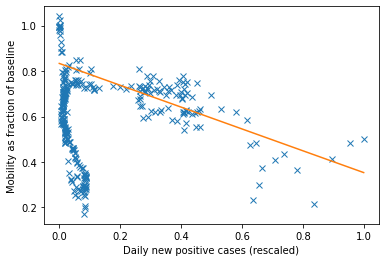

In [11]:
SPLIT = 200

plt.plot(cases, trans, 'x')
plt.xlabel("Daily new positive cases (rescaled)")
plt.ylabel("Mobility as fraction of baseline")

c, m = poly.polyfit(cases[SPLIT:], trans[SPLIT:], 1)
plt.plot(cases, (m * cases) + c, '-')

plt.show()

Following Hannah's suggestion and repeating using R instead of cases

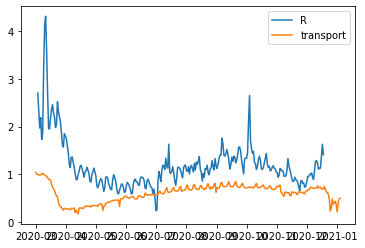

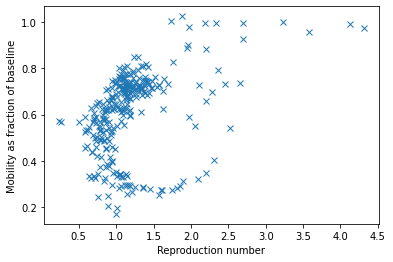

In [12]:
dates, R, trans = [], [], []

for date in df['date']:
  try:
    R.append(float(uk.loc[uk['date'] == date]['reproduction_rate']))
    trans.append(df.loc[df['date'] == date]['mean'])
    dates.append(date)
  except:
    continue

# R = np.array(R)
# R = (R - np.min(R))/(np.max(R) - np.min(R))
# trans = np.array(trans)
# trans = (trans - np.min(trans))/(np.max(trans) - np.min(trans))


plt.plot(dates, R, label='R')
plt.plot(dates, trans, label='transport')
plt.legend()
plt.show()

SPLIT = 0

plt.plot(R, trans, 'x')
plt.xlabel("Reproduction number")
plt.ylabel("Mobility as fraction of baseline")

# c, m = poly.polyfit(R[SPLIT:], R[SPLIT:], 1)
# plt.plot(R, (m * R) + c, '-')

plt.show()